In [1]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [2]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['id'] = str(compute_signal_hash(sample))
    eeg = eeg.set_index('id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)
ddf

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [3]:
df = ddf.compute()
df

sig_ids = list(set(df.index.to_list()))
sig_ids

['ac7e2a92c',
 'd8ac72718',
 '294f15234',
 '83fc70a87',
 'e943d8071',
 'edf43d851',
 'dfe410100',
 '784f915b7',
 'f98e0147c',
 'a4866b768',
 '8cb20395b',
 '2ad53794c',
 '3412bba45',
 'b62ebd08d',
 '29fafdd8f',
 'e19f767d6',
 '2d9f98444',
 'a7761b05f',
 '733af13ac',
 '93d14b4e3',
 'a5f5a0de4',
 'e1521ed88',
 '866bd3fec',
 '62b6cb9c0',
 'e4e4ab3a1',
 '31eb59b57',
 '3c2894fab',
 '1ab60e9eb',
 '7d92110bc',
 'f01a73f05',
 '3ec932a58',
 '10060abc4',
 '5b6710e31',
 'a6b49944e',
 '6fde86346',
 '777ad533c',
 '67271fc3c',
 'aad8d4193',
 'ee8f8d000',
 '6006f5e46',
 '128af48d7',
 '2cd59bfe3',
 '120375b18',
 '5eec66ecb',
 '305295155',
 'ad30a132c',
 'afbbca12d',
 'd880c8ed9',
 'ab4c5ebd3',
 'a2765befa',
 '3bbac64c9',
 '0ea91c9c1',
 'd69edd0e6',
 '78a6537a2',
 '2b764e53b',
 '44e034324',
 '40858c7ee',
 'b044d1bbc',
 'b70df112d',
 'f73a7e258',
 '8b0013ff7',
 'cfd28e6c0',
 '8c8bbcbed',
 '1f6eb153b',
 'f7c521c24',
 '51d7497a2',
 '3636e9f35',
 'c354bbbd7',
 '7b4ad7da9',
 'aa557b385',
 'c37803e20',
 'a018

In [4]:
sig1 = ddf.loc['ec2a8e98d'].compute()
sig1

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
id,,,,,,,,,,,,,,,,,,,
ec2a8e98d,12.390000,9.080000,-5.650000,33.340000,16.690001,22.990000,-5.870000,45.020000,91.080002,29.030001,6.580000,-47.340000,50.389999,26.320000,3.310000,10.680000,-12.160000,45.570000,35.75
ec2a8e98d,-22.879999,-4.470000,-6.090000,24.020000,13.990000,17.610001,0.810000,41.869999,87.900002,26.340000,6.180000,-42.810001,48.700001,25.680000,7.300000,11.690000,-11.200000,46.400002,37.57
ec2a8e98d,-35.770000,-16.549999,-0.580000,11.020000,2.820000,6.530000,-9.130000,34.119999,75.760002,11.650000,-6.260000,-53.369999,39.240002,14.600000,1.530000,0.870000,-20.049999,35.490002,29.23
ec2a8e98d,-13.310000,18.969999,11.560000,16.100000,0.090000,12.810000,6.050000,37.639999,78.099998,12.090000,-5.640000,-46.189999,42.529999,17.490000,-5.360000,5.150000,-12.950000,37.820000,31.60
ec2a8e98d,-32.540001,19.940001,12.040000,23.740000,4.320000,17.740000,10.620000,45.840000,83.510002,14.980000,-0.820000,-36.680000,46.590000,20.370001,-2.270000,9.790000,-7.170000,39.680000,37.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ec2a8e98d,-121.769997,55.470001,-37.790001,-110.839996,-78.500000,-20.500000,-30.280001,-128.529999,-47.049999,-88.160004,-36.700001,-60.750000,-94.870003,-116.330002,54.700001,-44.250000,-18.790001,-35.560001,7.47
ec2a8e98d,-140.589996,44.259998,-66.930000,-131.259995,-106.120003,-44.279999,-32.360001,-127.150002,-59.369999,-103.029999,-48.520000,-64.040001,-94.620003,-119.120003,54.730000,-46.639999,-7.720000,-33.770000,13.01
ec2a8e98d,-177.429993,14.850000,-61.500000,-150.789993,-135.970001,-71.669998,-42.900002,-131.759995,-68.650002,-116.900002,-62.180000,-68.139999,-94.160004,-119.699997,42.139999,-51.709999,-20.660000,-33.400002,8.13


In [5]:
## MNE setup
import mne
import numpy as np

mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
mne_info.set_montage('standard_1020')
    
sig1_data = np.array(sig1.transpose())
sig1_data = np.nan_to_num(sig1_data)
    
raw = mne.io.RawArray(sig1_data, mne_info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

Creating RawArray with float64 data, n_channels=19, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    49.995 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [6]:
# Apply filters
from src.preprocessing import notch_filter, bp_filter, standardize

l_freq = 1.0
h_freq = 70.0

df = notch_filter(df, 60)
df = bp_filter(df, 1.0, 70)
df = standardize(df)
df

Creating RawArray with float64 data, n_channels=19, n_times=10000000
    Range : 0 ... 9999999 =      0.000 ... 49999.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


Creating RawArray with float64 data, n_channels=19, n_times=10000000
    Range : 0 ... 9999999 =      0.000 ... 49999.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    7.0s


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
id,,,,,,,,,,,,,,,,,,,
db76e9927,-0.358759,1.578162,0.622663,-0.660394,-1.209209,-0.394399,0.784306,0.806612,1.145476,0.513598,-1.380129,-1.178880,-0.084640,0.384806,1.579776,0.572196,-1.950236,-0.987145,0.216196
db76e9927,0.093783,1.296192,0.574898,-1.681821,-1.295806,-0.217123,0.315114,1.365653,0.815609,-1.133318,-1.382836,-0.411701,0.128509,0.903011,1.789717,0.642637,-1.265056,-0.613207,0.075747
db76e9927,0.061048,1.455427,0.728026,-1.826660,-1.062345,-0.202941,0.055641,1.928031,1.149419,-1.164770,-1.153550,-0.763313,0.105338,1.234197,0.805129,-0.104989,-0.889405,-0.668347,0.314066
db76e9927,0.521842,1.111046,0.385727,-1.577889,-0.797725,0.117748,0.152667,1.476937,0.519251,-1.688054,-1.140100,-0.191842,0.689475,1.791900,0.499601,-1.385861,-1.095527,-0.082454,0.693257
db76e9927,1.315258,1.196277,0.167834,-0.857804,-0.711531,0.131882,0.214946,0.627445,0.377539,-1.709879,-1.466293,0.017657,0.357584,1.835375,0.874360,-1.818273,-1.007563,-0.095704,0.550890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,1.452691,-0.210558,-0.492525,1.014448,0.617263,0.309325,0.126559,-0.480378,1.228044,1.413593,-0.133942,-0.160932,-0.331164,0.101733,0.637515,0.202091,-0.825493,-2.419308,-2.048960
bbdf2f28e,0.516668,-1.086366,-0.980298,0.100393,0.140696,0.641374,1.289093,0.017183,-1.416835,-0.685799,0.518389,1.573385,1.760938,-0.203149,-1.688528,-0.201256,0.111158,-1.456036,1.048988
bbdf2f28e,2.826115,0.790033,0.444021,-0.741464,-0.915052,1.056363,-0.561535,-0.736579,1.206857,-0.420858,-1.176683,0.040314,0.361949,0.344895,0.167977,0.207614,-0.712273,-1.639740,-0.541954


In [7]:
# Extracting top 3 channels based on variance for all samples
# 1000 samples computation duration = approx. 4 minutes for M1
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(df, sig_ids, 1000) # 10 samples for testing
top_channels_df # NEED TO EXTRACT FEATURES FROM CHANNELS IN THIS DATA STRUCTURE

,0,1,2
ac7e2a92c,Fp1,O2,Fp2
d8ac72718,O2,Fp1,Fp2
294f15234,Fp1,O2,Fp2
83fc70a87,Fp1,O2,Fp2
e943d8071,O2,Fp1,O1
...,...,...,...
bfbfd93ce,Fp1,O2,O1
6988c170f,O2,Fp1,Fp2
1ec65611a,O2,Fp1,O1
46826e76c,Fp1,O2,Fp2


In [8]:
from src.feature_extraction import extract_features_all_samples

feature_extracted = extract_features_all_samples(df, top_channels_df)
feature_extracted

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
ac7e2a92c,1.123423,-0.005934,3.818748,-3.757293,1.263988,-0.000135,0.00254,2.574248,4.932709,4.159999,126411491.044589
d8ac72718,1.105051,-0.001254,3.890853,-3.803284,1.222264,-0.016297,0.045374,2.625493,4.964039,3.951515,122229125.359308
294f15234,1.123016,0.00045,3.853048,-3.821106,1.262751,0.00755,-0.017646,2.614711,4.943425,4.21047,126275473.426302
83fc70a87,1.112284,0.002697,3.876749,-3.741886,1.238187,-0.000845,0.014312,2.644899,4.969875,4.086109,123820504.675991
e943d8071,1.098407,-0.001953,3.75887,-3.824184,1.20809,-0.003743,0.046092,2.655401,4.96031,3.911292,120820100.942206
...,...,...,...,...,...,...,...,...,...,...,...
bfbfd93ce,1.097843,0.001223,3.863537,-3.605628,1.206283,-0.006892,0.031581,2.702989,4.981858,3.959088,120631048.031165
6988c170f,1.110772,0.001418,3.805448,-3.828587,1.235355,-0.007271,0.014885,2.687726,4.967342,4.148119,123536248.534086
1ec65611a,1.110009,0.008287,3.760784,-3.812433,1.233716,0.007509,0.017172,2.633161,4.967368,4.049408,123382558.624428
46826e76c,1.108323,0.007369,3.879432,-3.750281,1.229251,0.010904,0.012995,2.634574,4.954746,4.007954,122932542.506664


In [10]:
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata

,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [11]:
input_df = pd.merge(feature_extracted, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
ac7e2a92c,1.123423,-0.005934,3.818748,-3.757293,1.263988,-0.000135,0.00254,2.574248,4.932709,4.159999,126411491.044589,GPD
d8ac72718,1.105051,-0.001254,3.890853,-3.803284,1.222264,-0.016297,0.045374,2.625493,4.964039,3.951515,122229125.359308,GPD
294f15234,1.123016,0.00045,3.853048,-3.821106,1.262751,0.00755,-0.017646,2.614711,4.943425,4.21047,126275473.426302,LPD
83fc70a87,1.112284,0.002697,3.876749,-3.741886,1.238187,-0.000845,0.014312,2.644899,4.969875,4.086109,123820504.675991,GRDA
e943d8071,1.098407,-0.001953,3.75887,-3.824184,1.20809,-0.003743,0.046092,2.655401,4.96031,3.911292,120820100.942206,LPD
...,...,...,...,...,...,...,...,...,...,...,...,...
bfbfd93ce,1.097843,0.001223,3.863537,-3.605628,1.206283,-0.006892,0.031581,2.702989,4.981858,3.959088,120631048.031165,LPD
6988c170f,1.110772,0.001418,3.805448,-3.828587,1.235355,-0.007271,0.014885,2.687726,4.967342,4.148119,123536248.534086,GRDA
1ec65611a,1.110009,0.008287,3.760784,-3.812433,1.233716,0.007509,0.017172,2.633161,4.967368,4.049408,123382558.624428,Other


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)

Accuracy: 0.205
Precision: 0.042025
Recall: 0.205
F1 Score: 0.06975103734439833


/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

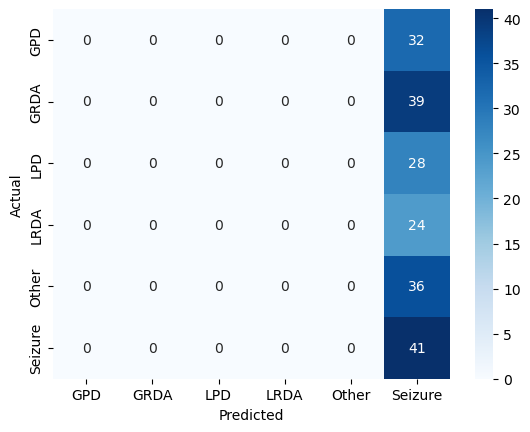

In [15]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
cm_df = pd.DataFrame(cm, columns=le.inverse_transform([0,1,2,3,4,5]), index=le.inverse_transform([0,1,2,3,4,5]))

sns.heatmap(cm_df, annot=True, cmap='Blues').set(xlabel='Predicted', ylabel='Actual')


Accuracy: 0.18
Precision: 0.17866783813652884
Recall: 0.18
F1 Score: 0.17885347985347985


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

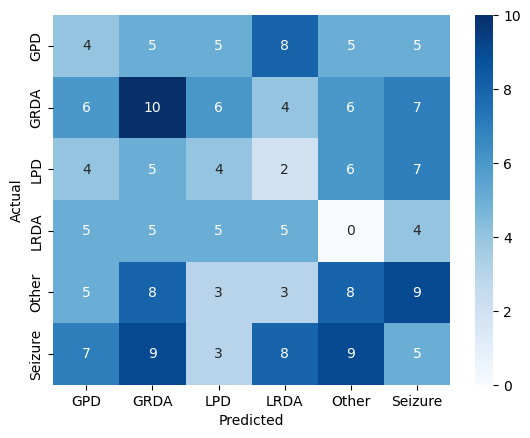

In [17]:
from sklearn import tree


clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree, average='weighted')
recall = recall_score(y_test, y_pred_tree, average='weighted')
f1 = f1_score(y_test, y_pred_tree, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
cm_df = pd.DataFrame(cm, columns=le.inverse_transform([0,1,2,3,4,5]), index=le.inverse_transform([0,1,2,3,4,5]))

sns.heatmap(cm_df, annot=True, cmap='Blues').set(xlabel='Predicted', ylabel='Actual')

Accuracy: 0.195
Precision: 0.19254221295397767
Recall: 0.195
F1 Score: 0.19068928156085377


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

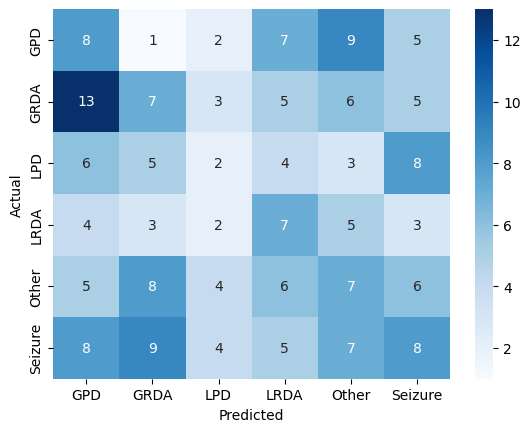

In [20]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=21)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')
f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
cm_df = pd.DataFrame(cm, columns=le.inverse_transform([0,1,2,3,4,5]), index=le.inverse_transform([0,1,2,3,4,5]))

sns.heatmap(cm_df, annot=True, cmap='Blues').set(xlabel='Predicted', ylabel='Actual')

Accuracy: 0.205
Precision: 0.042025
Recall: 0.205
F1 Score: 0.06975103734439833


/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

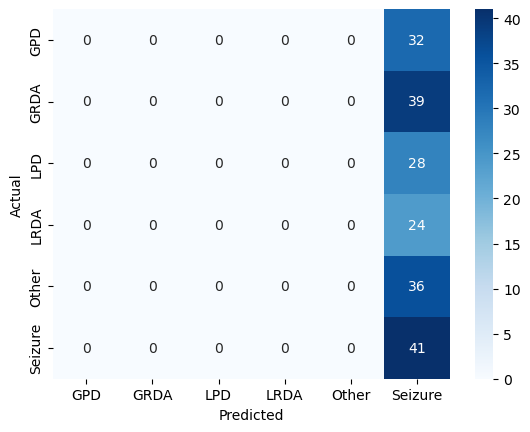

In [22]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm, columns=le.inverse_transform([0,1,2,3,4,5]), index=le.inverse_transform([0,1,2,3,4,5]))

sns.heatmap(cm_df, annot=True, cmap='Blues').set(xlabel='Predicted', ylabel='Actual')

In [ ]:
# df_model = pd.DataFrame()
# for idx, row in top_channels_df.iterrows():
#   temp = df.loc[idx]
#   selected_columns = temp[["Fp1", "O2", "Fp2", "O1"]]
#   df_model = pd.concat([df_model, selected_columns])
# df_model

,Fp1,O2,Fp2,O1
id,,,,
d128c9ebd,-0.923302,0.766875,0.028176,-0.455157
d128c9ebd,0.867578,-2.510445,-0.089251,-0.455618
d128c9ebd,-1.647884,-0.257054,0.493182,-1.007211
d128c9ebd,0.701803,-0.440238,-0.273099,1.046773
d128c9ebd,-0.404222,0.856649,-0.493801,0.988441
...,...,...,...,...
fb2bfb3db,-1.275576,0.872572,-1.560284,1.430474
fb2bfb3db,-0.439766,0.729472,-1.678198,-0.623653
fb2bfb3db,0.882909,0.944848,-0.501423,-0.705514


In [ ]:
# from sklearn.model_selection import train_test_split

# # Drop the column with NaN values
# # Transform the DataFrame into a 3D array
# n_features = 4  # Number of EEG channels used
# time_steps = 10000  # Rows per id
# n_sequences = len(df_model) // time_steps  # Total number of sequences

# # Initialize an empty array for the transformed data
# X = np.empty((n_sequences, time_steps, n_features))

# # Fill the array with data from the DataFrame
# for i, (idx, group) in enumerate(df_model.groupby('id')):
#     X[i] = group[['Fp1', 'O2', 'Fp2', 'O1']].values

# y = metadata.expert_consensus
# y = y.apply(lambda x: 1 if x == 'Seizure' else 0)

# # Split the data into training and test sets
# X_train = X[:400]
# y_train = y[:400]
# X_test = X[800:]
# y_test = y[800:]
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)


In [ ]:
# import torch
# import torch.nn as nn

# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         # LSTM Layer
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
#         # Fully connected layer
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return torch.sigmoid(out)

# # Model initialization
# input_dim = 4  # Number of channels
# hidden_dim = 128  # Number of hidden units
# num_layers = 2  # Number of LSTM layers

# model = LSTMModel(input_dim, hidden_dim, output_dim=1, num_layers=num_layers)


/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Ensure X_train, X_test, y_train, y_test are all numpy arrays before proceeding
# X_train = X_train.values if isinstance(X_train, pd.Series) else X_train
# X_test = X_test.values if isinstance(X_test, pd.Series) else X_test
# y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
# y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

# # Now, convert them into tensors
# train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
# test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# # DataLoader
# batch_size = 64
# train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = LSTMModel(input_dim=4, hidden_dim=128, output_dim=1, num_layers=2).to(device)
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# num_epochs = 10
# criterion = nn.BCEWithLogitsLoss()
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs.squeeze(), labels)
        
#         # Backward and optimize
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/10], Loss: 0.8613
Epoch [2/10], Loss: 0.7645
Epoch [3/10], Loss: 0.6966
Epoch [4/10], Loss: 0.6940
Epoch [5/10], Loss: 0.6936
Epoch [6/10], Loss: 0.6935
Epoch [7/10], Loss: 0.6934
Epoch [8/10], Loss: 0.6934
Epoch [9/10], Loss: 0.6933
Epoch [10/10], Loss: 0.6933


In [ ]:
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         predicted = (outputs.squeeze() > 0.5).float()
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print(f'Accuracy: {100 * correct / total}')

Accuracy: 81.0
